# Assignment 3



*   Babandeep Singh
*   Robin Beura
*   Rahul Gera
*   Sanghamitra Muhuri
*   Yash Patel


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/Shared drives/IDS 576/Assignment 3')

Mounted at /content/drive


In [ ]:
dir = os.getcwd()

In [ ]:
# pip install pytorch-nlp
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

####Data Loading 

In [ ]:
# Representing words as vectors
SOS_token = 0
EOS_token = 1

"""using class - Lang which has word → index (word2index) and index → word (index2word) dictionaries
and count of each word word2count to use to later replace rare words.
"""
class Lang:
  
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [ ]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = s.lower().strip()    # lowercase for consistency
    s = re.sub(r"([.!?])", r" \1", s)    # replacing punctuations with first matched group
    return s

Reading data from hin-eng.zip

In [ ]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open(dir+'/.data/hin.txt', encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')][:-1] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [ ]:
# Taking only sentences less than 40 words
MAX_LENGTH = 40
 
def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH 
 
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [ ]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

####Sequence to Sequence Modelling:

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)


Preparing Training Data

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

Training the Model

In [ ]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()
    %matplotlib inline

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

Helper function to track time and progress

In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [ ]:
#Function for plotting results
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings("ignore", module="matplotlib")
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

####Evaluation

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    from nltk.translate.bleu_score import sentence_bleu
    
    for i in range(n):
        pair = random.choice(pairs)
        print('Input: ', pair[0])
        print('Output: ', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('Predicted: ', output_sentence)
        act = pair[1].split()
        pred = output_sentence.split()
        print('Cumulative 1-gram: %f' % sentence_bleu([act], pred, weights=(1, 0, 0, 0)))
        print('Cumulative 2-gram: %f' % sentence_bleu([act], pred, weights=(0.5, 0.5, 0, 0)))
        print('Cumulative 3-gram: %f' % sentence_bleu([act], pred, weights=(0.33, 0.33, 0.33, 0)))
        print('Cumulative 4-gram: %f' % sentence_bleu([act], pred, weights=(0.25, 0.25, 0.25, 0.25)))
        score = sentence_bleu([act], pred)   ##### using BLEU here
        print(score)
        print('')

Helper Functions end here

###Training and Evaluation

####**MODEL 1** Hindi to English

In [ ]:
# in case we want to reverse i/o pair
input_lang, output_lang, pairs = prepareData('eng', 'hin', True)  # True indicates Hindi to English translation
print(random.choice(pairs))

Reading lines...
Read 2773 sentence pairs
Trimmed to 2773 sentence pairs
Counting words...
Counted words:
hin 3055
eng 2495
['घटना कब हुई ?', 'when did the accident happen ?']


0m 41s (- 19m 52s) (2000 3%) 4.5267
1m 19s (- 18m 32s) (4000 6%) 4.2157
1m 57s (- 17m 39s) (6000 10%) 3.8836
2m 36s (- 16m 56s) (8000 13%) 3.6928
3m 14s (- 16m 14s) (10000 16%) 3.4281
3m 54s (- 15m 36s) (12000 20%) 3.1464
4m 33s (- 14m 59s) (14000 23%) 2.9512
5m 13s (- 14m 23s) (16000 26%) 2.6758
5m 53s (- 13m 45s) (18000 30%) 2.4215
6m 33s (- 13m 6s) (20000 33%) 2.1819
7m 12s (- 12m 27s) (22000 36%) 2.0042
7m 51s (- 11m 47s) (24000 40%) 1.7159
8m 31s (- 11m 9s) (26000 43%) 1.6124
9m 11s (- 10m 30s) (28000 46%) 1.4179
9m 51s (- 9m 51s) (30000 50%) 1.2407
10m 30s (- 9m 12s) (32000 53%) 1.0681
11m 10s (- 8m 32s) (34000 56%) 0.9223
11m 50s (- 7m 53s) (36000 60%) 0.8358
12m 30s (- 7m 14s) (38000 63%) 0.7199
13m 10s (- 6m 35s) (40000 66%) 0.6236
13m 51s (- 5m 56s) (42000 70%) 0.5474
14m 31s (- 5m 16s) (44000 73%) 0.4220
15m 11s (- 4m 37s) (46000 76%) 0.4027
15m 51s (- 3m 57s) (48000 80%) 0.3485
16m 32s (- 3m 18s) (50000 83%) 0.3022
17m 12s (- 2m 38s) (52000 86%) 0.2224
17m 53s (- 1m 59s) (5

<Figure size 432x288 with 0 Axes>

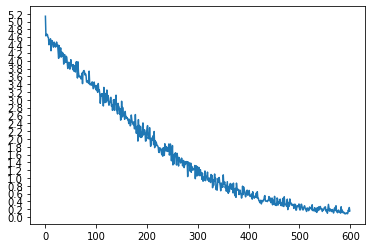

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 60000, print_every=2000)   #### 60000,2000

In [ ]:
evaluateRandomly(encoder1, attn_decoder1)

Input:  तुम्हे बस उसकी सलाह के मुताबिक काम करना होगा।
Output:  all you have to do is follow his advice .
Predicted:  all you have to do is follow his advice . 
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
Cumulative 4-gram: 1.000000
1.0

Input:  उसकी तीन बेटियाँ हैं।
Output:  he has three daughters .
Predicted:  he has three daughters . 
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
Cumulative 4-gram: 1.000000
1.0

Input:  तुम हमारे साथ आओगे क्या ?
Output:  will you go with us ?
Predicted:  will you go with us ? 
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
Cumulative 4-gram: 1.000000
1.0

Input:  मेरे पास ज़्यादा समय नहीं है।
Output:  i do not have much time .
Predicted:  i do not have much time . 
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
Cumulative 4-gram: 1.000000
1.0

Input:  क़ैदी को रिहा कर दिया गया।
Output:  the prisoner w

Visualizing Attention output in matrix form with columns being input and rows being output steps:

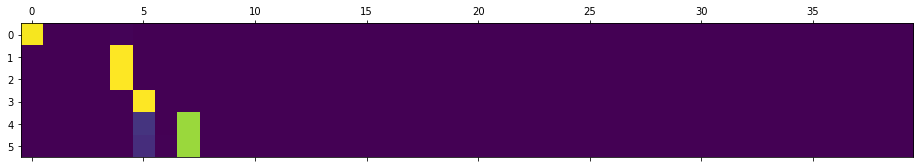

In [ ]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "कैसा चल रहा है ?")
plt.matshow(attentions.numpy())

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)

def evaluateAndShow1(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))

input = कैसा चल रहा है ?
output = how is it going ? 


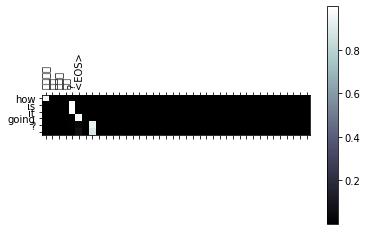

In [ ]:
# Hindi to English test sentence
evaluateAndShowAttention("कैसा चल रहा है ?")

####**MODEL 2** English to Hindi


In [ ]:
input_lang, output_lang, pairs = prepareData('eng', 'hin', False)
print(random.choice(pairs))

Reading lines...
Read 2773 sentence pairs
Trimmed to 2773 sentence pairs
Counting words...
Counted words:
eng 2495
hin 3055
['have you ever been to africa ?', 'आप कभी अफ़्रीका गए हुए हैं क्या ?']


#####**Vanilla Model**

0m 41s (- 20m 4s) (2000 3%) 4.9585
1m 21s (- 18m 54s) (4000 6%) 4.8311
2m 0s (- 18m 8s) (6000 10%) 4.4881
2m 40s (- 17m 24s) (8000 13%) 4.1107
3m 21s (- 16m 46s) (10000 16%) 3.8200
4m 2s (- 16m 8s) (12000 20%) 3.4662
4m 43s (- 15m 32s) (14000 23%) 3.2142
5m 25s (- 14m 53s) (16000 26%) 2.9618
6m 6s (- 14m 16s) (18000 30%) 2.5800
6m 49s (- 13m 38s) (20000 33%) 2.3696
7m 31s (- 12m 59s) (22000 36%) 2.0857
8m 13s (- 12m 20s) (24000 40%) 1.9117
8m 56s (- 11m 41s) (26000 43%) 1.7156
9m 39s (- 11m 1s) (28000 46%) 1.5299
10m 21s (- 10m 21s) (30000 50%) 1.3374
11m 4s (- 9m 41s) (32000 53%) 1.2703
11m 46s (- 9m 0s) (34000 56%) 1.0165
12m 27s (- 8m 18s) (36000 60%) 0.9769
13m 8s (- 7m 36s) (38000 63%) 0.8652
13m 49s (- 6m 54s) (40000 66%) 0.7530
14m 30s (- 6m 12s) (42000 70%) 0.6478
15m 11s (- 5m 31s) (44000 73%) 0.5856
15m 51s (- 4m 49s) (46000 76%) 0.5223
16m 32s (- 4m 8s) (48000 80%) 0.4491
17m 12s (- 3m 26s) (50000 83%) 0.4001
17m 53s (- 2m 45s) (52000 86%) 0.3539
18m 34s (- 2m 3s) (54000 90%

<Figure size 432x288 with 0 Axes>

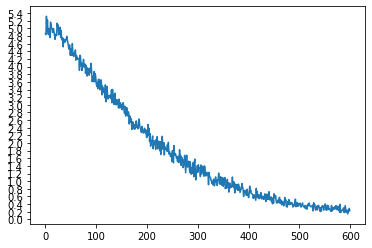

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 60000, print_every=2000)  ### 60000,2000

In [ ]:
evaluateRandomly(encoder1, attn_decoder1)

Input:  every man should learn how to cook .
Output:  हर आदमी को खाना बनाना सीखना चाहिए।
Predicted:  हर आदमी को खाना बनाना सीखना चाहिए। 
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
Cumulative 4-gram: 1.000000
1.0

Input:  i never liked biology .
Output:  मुझे जीव विज्ञान कभी भी पसंद नहीं था।
Predicted:  मुझे जीव विज्ञान कभी भी पसंद नहीं था। 
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
Cumulative 4-gram: 1.000000
1.0

Input:  he's always dissatisfied .
Output:  वह कभी भी संतुष्ट नहीं होता।
Predicted:  वह कभी भी संतुष्ट नहीं होता। 
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
Cumulative 4-gram: 1.000000
1.0

Input:  she likes her school a lot .
Output:  उसे अपना स्कूल बहुत पसंद है।
Predicted:  उसे अपना स्कूल बहुत पसंद है। 
Cumulative 1-gram: 1.000000
Cumulative 2-gram: 1.000000
Cumulative 3-gram: 1.000000
Cumulative 4-gram: 1.000000
1.0

Input:  that's my fault .
Output:

input = how are you ?
output = तुम कैसे हो ? 


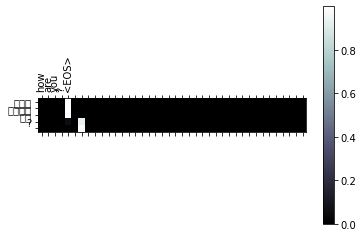

In [ ]:
# English to Hindi test sentence
evaluateAndShowAttention("how are you ?")

#####Inputing sentences from English to Vanilla Model and input resultant translated sentences to Model 1. 

In [ ]:
# Sentence 1: Model2 -> Hindi
evaluateAndShow1("how are you ?")

input = how are you ?
output = आप कैसे हो ? 


In [ ]:
# Sentence 1: Model1 -> English
evaluateAndShow1("आप कैसे हो ?")

input = आप कैसे हो ?
output = how are you ? 


In [ ]:
# Sentence 2: Model2 -> Hindi
evaluateAndShow1("i am waiting for you")

input = i am waiting for you
output = मैं तुम्हें कुछ बताने के लिए हूँ। 


In [ ]:
# Sentence 2: Model1 -> English
evaluateAndShow1("मैं तुम्हें कुछ बताने के लिए हूँ। ")

input = मैं तुम्हें कुछ बताने के लिए हूँ। 
output = i want to go to the bank . 


In [ ]:
# Sentence 3: Model2 -> Hindi
evaluateAndShow1("it's cold outside")

input = it's cold outside
output = क्या पता हो रहा है। 


In [ ]:
# Sentence 3: Model1 -> English
evaluateAndShow1("क्या पता हो रहा है। ")

input = क्या पता हो रहा है। 
output = it's starting the book . 


##### **Model 2 using GloVe Embeddings**

Loading GloVe 100 Dimemsional Embeddings:

In [ ]:
from torchtext.vocab import GloVe
from torchtext import data
TEXT = data.Field(tokenize='spacy')
TEXT.build_vocab(pairs,max_size=25000, vectors = GloVe(name='6B', dim=100))

In [ ]:
input_lang, output_lang, pairs = prepareData('eng', 'hin', False)
print(random.choice(pairs))

Reading lines...
Read 2773 sentence pairs
Trimmed to 2773 sentence pairs
Counting words...
Counted words:
eng 2495
hin 3055
['how long have you been abroad ?', 'आप विदेश में कबसे हैं ?']


Training Model using GloVe vectors

In [ ]:
INPUT_DIM = len(TEXT.vocab) # updating new vocab
hidden_size = 100 # Glove dimension is 100
encoder2 = EncoderRNN(INPUT_DIM, hidden_size).to(device)
attn_decoder2 = AttnDecoderRNN(hidden_size, INPUT_DIM, dropout_p=0.1).to(device)

In [ ]:
INPUT_DIM

5266

In [ ]:
pretrained_embeddings = TEXT.vocab.vectors
encoder2.embedding.weight.data.copy_(pretrained_embeddings)
attn_decoder2.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')

0m 34s (- 16m 34s) (2000 3%) 4.6697
1m 8s (- 16m 5s) (4000 6%) 5.1128
1m 43s (- 15m 35s) (6000 10%) 5.0855
2m 19s (- 15m 4s) (8000 13%) 5.0144
2m 54s (- 14m 31s) (10000 16%) 5.0252
3m 30s (- 14m 0s) (12000 20%) 4.9877
4m 6s (- 13m 28s) (14000 23%) 4.9852
4m 42s (- 12m 56s) (16000 26%) 4.9461
5m 18s (- 12m 22s) (18000 30%) 4.8913
5m 54s (- 11m 48s) (20000 33%) 4.8101
6m 29s (- 11m 13s) (22000 36%) 4.7002
7m 5s (- 10m 38s) (24000 40%) 4.6631
7m 41s (- 10m 3s) (26000 43%) 4.5795
8m 17s (- 9m 28s) (28000 46%) 4.4913
8m 53s (- 8m 53s) (30000 50%) 4.4094
9m 28s (- 8m 17s) (32000 53%) 4.3137
10m 4s (- 7m 42s) (34000 56%) 4.3014
10m 40s (- 7m 6s) (36000 60%) 4.2910
11m 16s (- 6m 31s) (38000 63%) 4.1565
11m 52s (- 5m 56s) (40000 66%) 4.1722
12m 28s (- 5m 20s) (42000 70%) 4.0845
13m 4s (- 4m 45s) (44000 73%) 4.0484
13m 40s (- 4m 9s) (46000 76%) 3.9716
14m 17s (- 3m 34s) (48000 80%) 3.9629
14m 53s (- 2m 58s) (50000 83%) 3.8900
15m 30s (- 2m 23s) (52000 86%) 3.8841
16m 6s (- 1m 47s) (54000 90%) 3.

<Figure size 432x288 with 0 Axes>

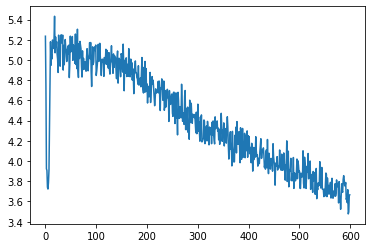

In [ ]:
trainIters(encoder2, attn_decoder2, 60000, print_every=2000)

Evaluating Performance for Model 2

####Inputing 5 sentences from English to Model2 and input resultant translated sentences to Model 1. 

In [ ]:
def evaluateAndShow2(input_sentence):
    output_words, attentions = evaluate(
        encoder2, attn_decoder2, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))

In [ ]:
# Sentence 1: Model2 -> Hindi
evaluateAndShow2("how are you ?")

input = how are you ?
output = आप कहाँ हो ? 


In [ ]:
# Sentence 1: Model1 -> English
evaluateAndShow1("आप कहाँ हो ?")

input = आप कहाँ हो ?
output = where are you ? 


In [ ]:
# Sentence 2: Model2 -> Hindi
evaluateAndShow2("i am waiting for you")

input = i am waiting for you
output = मैं क्या मैं सकता हूँ ? 


In [ ]:
# Sentence 2: Model1 -> English
evaluateAndShow1("मैं क्या मैं सकता हूँ ? ")

input = मैं क्या मैं सकता हूँ ? 
output = i was my pen to me ? 


In [ ]:
# Sentence 3: Model2 -> Hindi
evaluateAndShow2("it's cold outside")

input = it's cold outside
output = मुश्किल क्या ! 


In [ ]:
# Sentence 3: Model1 -> English
evaluateAndShow1("मुश्किल क्या !")

input = मुश्किल क्या !
output = what ! 


In [ ]:
# Sentence 4: Model2 -> Hindi
evaluateAndShow2("we are playing today")

input = we are playing today
output = हम कल से यकीन नहीं 


In [ ]:
# Sentence 4: Model1 -> English
evaluateAndShow1("हम कल से यकीन नहीं ")

input = हम कल से यकीन नहीं 
output = we had not go to that . 


In [ ]:
# Sentence 5: Model2 -> Hindi
evaluateAndShow2("let's finish this")

input = let's finish this
output = मुश्किल क्या हो ! 


In [ ]:
# Sentence 5: Model1 -> English
evaluateAndShow1("मुश्किल क्या हो !")

input = मुश्किल क्या हो !
output = what it ! 


In conclusion,  the Vanilla model gives better results when compared to that with GloVe embeddings for the Hindi language translation. Modified GloVe embeddings would perform better when used for Indian Languages. This is because our Hindi vocabulary has relatively fewer words as compared to other languages. If we increase the vocabulary or use modified embeddings, we'll achieve better results.

(Refer: https://www.aclweb.org/anthology/2020.sltu-1.49.pdf) 

##References:

1. https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html